# 5.SQL and Dataframes

References:

* Spark-SQL, <https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes>


# 5.1  Example Walkthrough
Follow the Spark SQL and Dataframes Examples below!

### Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [1]:
import os, sys
os.chdir(os.path.join(os.environ["HOME"], "exercise-students-2020/05_SQL"))
%pwd

'/home/jupyter-ter-akopyan-118531-8d8bf/exercise-students-2020/05_SQL'

In [2]:
# Initialize PySpark
import os, sys
APP_NAME = "PySpark Lecture"
SPARK_MASTER="local[1]"
import pyspark
import pyspark.sql
from pyspark.sql import Row
conf=pyspark.SparkConf()
conf=pyspark.SparkConf().setAppName(APP_NAME).set("spark.local.dir", os.path.join(os.getcwd(), "tmp"))
sc = pyspark.SparkContext(master=SPARK_MASTER, conf=conf)
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initiated...")

PySpark initiated...


### Hello, World!

Loading data, mapping it and collecting the records into RAM...

In [ ]:
# Load the text file using the SparkContext
csv_lines = sc.textFile("../data/example.csv")

# Map the data to split the lines into a list
data = csv_lines.map(lambda line: line.split(","))

# Collect the dataset into local RAM
data.collect()

### Creating Rows

Creating `pyspark.sql.Rows` out of your data so you can create DataFrames...

In [ ]:
# Convert the CSV into a pyspark.sql.Row
def csv_to_row(line):
    parts = line.split(",")
    row = Row(
      name=parts[0],
      company=parts[1],
      title=parts[2]
    )
    return row

# Apply the function to get rows in an RDD
rows = csv_lines.map(csv_to_row)

### Creating DataFrames from RDDs

Using the `RDD.toDF()` method to create a dataframe, registering the `DataFrame` as a temporary table with Spark SQL, and counting the jobs per person using Spark SQL.

In [ ]:
# Convert to a pyspark.sql.DataFrame
rows_df = rows.toDF()
rows_df.take(5)

In [ ]:
# Register the DataFrame for Spark SQL
rows_df.registerTempTable("executives")

# Generate a new DataFrame with SQL using the SparkSession
job_counts = spark.sql("""
SELECT
  name,
  COUNT(*) AS total
  FROM executives
  GROUP BY name
""")
job_counts.show()

# Go back to an RDD
job_counts.rdd.collect()

# 5.2-5.9 NASA DataSet

5.2 Create a Spark-SQL table with fields for IP/Host and Response Code from the NASA Log file! 

In [3]:
!tail -n5 /opt/data/nasa/NASA_access_log_Jul95

163.205.53.14 - - [28/Jul/1995:13:32:23 -0400] "GET /images/KSC-logosmall.gif HTTP/1.0" 200 1204
tiger2.ocs.lsu.edu - - [28/Jul/1995:13:32:23 -0400] "GET /shuttle/missions/missions.html HTTP/1.0" 200 8677
199.0.2.27 - - [28/Jul/1995:13:32:23 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 200 5866
tornado.umd.edu - - [28/Jul/1995:13:32:25 -0400] "GET /shuttle/missions/sts-74/sts-74-patch-small.gif HTTP/1.0" 200 5494
alyssa.p

In [4]:
# Load the text file using the SparkContext
nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")

In [5]:
# Convert the CSV into a pyspark.sql.Row
def nasa_to_row(line):
    parts = line.split(" ")
    row = Row(
      host=parts[0],
      res=parts[-2]
    )
    return row

# Apply the function to get rows in an RDD
nasa_rows = nasa_lines.filter(lambda x: '- -' in x).map(nasa_to_row)

In [6]:
# Convert to a pyspark.sql.DataFrame
nasa_df = nasa_rows.toDF()

In [7]:
nasa_df.take(5)

[Row(host='199.72.81.55', res='200'),
 Row(host='unicomp6.unicomp.net', res='200'),
 Row(host='199.120.110.21', res='200'),
 Row(host='burger.letters.com', res='304'),
 Row(host='199.120.110.21', res='200')]

5.3 Run an SQL query that outputs the number of occurrences of each HTTP response code!

In [8]:
# Register the DataFrame for Spark SQL
nasa_df.registerTempTable("nasalogs")

# Generate a new DataFrame with SQL using the SparkSession
res_counts = spark.sql("""
SELECT
  res,
  COUNT(*) AS total
  FROM nasalogs
  GROUP BY res
""")
res_counts.show()

+---+-------+
|res|  total|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+



5.4 Cachen Sie den Dataframe und führen Sie dieselbe Query nochmals aus! Messen Sie die Laufzeit für das Cachen und für die Ausführungszeit der Query!

In [9]:
from time import time

In [10]:
cstart = time()
nasa_df.cache().collect()
cend = time()
print('Cache runtime: %.2f' % (cend - cstart))

Cache runtime: 19.86


In [11]:
qstart = time()
res_counts = spark.sql("""
SELECT
  res,
  COUNT(*) AS total
  FROM nasalogs
  GROUP BY res
""")

res_counts.show()
qend = time()
print('Query runtime: %.3f' % (qend - qstart))

+---+-------+
|res|  total|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Query runtime: 1.296


5.5. Implement the same Query using the Dataframe API!

In [12]:
nasa_df.take(3)

[Row(host='199.72.81.55', res='200'),
 Row(host='unicomp6.unicomp.net', res='200'),
 Row(host='199.120.110.21', res='200')]

In [13]:
nasa_df.groupBy('res').count().show()

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+



5.6 Führen Sie diesselbe Query mit/ohne Cache und 8, 16 Cores aus! Dokumentieren und erklären Sie das Ergebnis!

In [14]:
def evaluate_num_cores(core = 8, cache = False):
    if cache:
        nasa_df.cache().count()
    else:
        nasa_df.unpersist()
    #spark.sparkContext.master = "local[{0}]".format(core)
    start = time()
    nasa_df.groupBy('res').count()
    return time() - start

In [39]:
for core in [8, 16]:
    for cache in [False, True]:
        sc.stop()
        sc = pyspark.SparkContext(master="local["+str(core)+"]", conf=conf)
        spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
        nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")
        nasa_rows = nasa_lines.filter(lambda x: '- -' in x).map(nasa_to_row)
        nasa_df = nasa_rows.toDF()
        print('Elapsed time for %d cores and caching=%s: %.2f s' % ((core), (cache), (evaluate_num_cores(core, cache = cache))))

+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time for 8 cores and caching=False: 2.63 s
+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time for 8 cores and caching=True: 0.29 s
+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time for 16 cores and caching=False: 2.32 s
+---+-------+
|res|  count|
+---+-------+
|200|1701534|
|302|  46573|
|501|     14|
|404|  10845|
|403|     54|
|500|     62|
|304| 132627|
|400|      5|
+---+-------+

Elapsed time for 16 cores and caching=True: 0.30 s


**Explanation**  

A job executed on 16 cores is slightly, but visibly faster than using 8 cores.

Using cache reduces possible gains of extra cores to statistical error if not making a 16-core job slower than the 8-core one.

5.7 Performance Analysis: 
* Create RDDs with 2x, 4x, 8x and 16x of the size of the NASA log dataset! Persist the dataset in the Spark Cache! Use an appropriate number of cores (e.g. 8 or 16)!
* Measure and plot the response times for all datasets using a constant number of cores!
* Plot the results!
* Explain the results!



In [44]:
def oversample(n):
    nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")\
    .filter(lambda x: '- -' in x)\
    .flatMap(lambda x: [x]*n)\
    .map(nasa_to_row)
    return nasa_lines.toDF()

In [35]:
def create_oversamples():
    oversamples = []
    for x in (2**p for p in range(1, 5)):
        tmp = oversample(x)
        tmp.cache().count()
        oversamples.append(tmp)
    return oversamples

In [36]:
oversamples = create_oversamples()

In [28]:
measures = {}
for i, df in enumerate(oversamples):
    start = time()
    df.groupBy('res').count().collect()
    end = time()
    measures[2**(i + 1)] = end - start

In [29]:
measures

{2: 0.2868630886077881,
 4: 0.328141450881958,
 8: 0.48810815811157227,
 16: 0.7264792919158936}

In [30]:
import matplotlib.pyplot as plt

<BarContainer object of 4 artists>

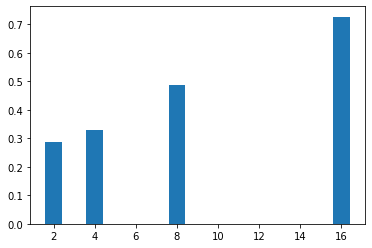

In [31]:
plt.bar(measures.keys(), measures.values())

**Explanation:**  
one could expect that processing 16x data set should take 8x longer than 2x dataset (2x -> 1s => 16x -> 8s),  
but according to the plotted results in the figure above we can observe different behaviour. In above plot we see  
that calculation time for our 16x dataset approximately increased by factor of 3.3 in comparison to 2x dataset.  

It may be related to a big, sequential overhead related to starting a new spark job that contributes to the most of the measured time. 

In [32]:
sc.stop()
sc = pyspark.SparkContext(master="local[1]", conf=conf)
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")
nasa_rows = nasa_lines.filter(lambda x: '- -' in x).map(nasa_to_row)
nasa_df = nasa_rows.toDF()

In [ ]:
oversamples = create_oversamples()

In [37]:
measures = {}
for i, df in enumerate(oversamples):
    start = time()
    df.groupBy('res').count().collect()
    end = time()
    measures[2**(i + 1)] = end - start

<BarContainer object of 4 artists>

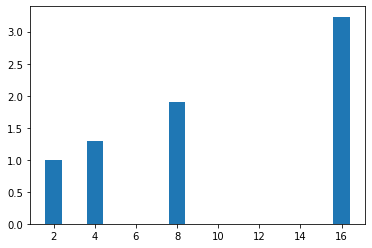

In [38]:
plt.bar(measures.keys(), measures.values())

5.8 Strong Scaling

  * **Measure the runtime for the query for 1, 2, 4, 8 and 16 cores for 1x and 16x datasets!** Datasets cached in Memory!
  * Compute the speedup and efficiency!
  * Plot the responses!
  * Explain the results!

In [45]:
measures = {1:{}, 16:{}}
for x in [2**x for x in range(5)]:
    for i in [1, 16]:
        # this code could be refactored to be a standalone function
        sc.stop()
        sc = pyspark.SparkContext(master="local["+str(x)+"]", conf=conf)
        spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
        nasa_lines = sc.textFile("/opt/data/nasa/NASA_access_log_Jul95")
        nasa_rows = nasa_lines.filter(lambda x: '- -' in x).map(nasa_to_row)
        nasa_df = nasa_rows.toDF()
        ###########################
        over_df = oversample(i).cache()
        start = time()
        over_df.groupBy('res').count().collect()
        end = time()
        measures[i][str(x) + " core"] = end - start

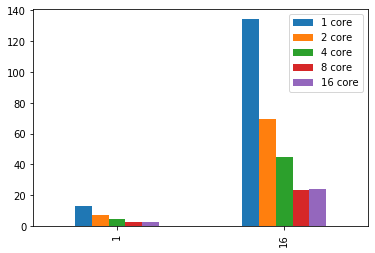

In [46]:
import pandas as pd
pd.DataFrame(measures).T.plot.bar()

In [47]:
import numpy as np

In [48]:
speedup = np.array([[measures[k]['1 core']/measures[k][i]  for i in measures[k] ] for k in measures]) 

In [49]:
efficiency = speedup/np.power(2,np.arange(5))

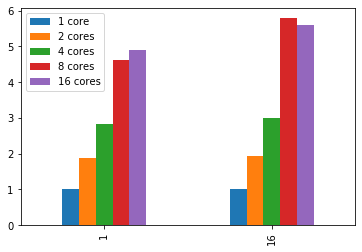

In [50]:
pd.DataFrame(speedup, columns=["1 core", "2 cores", "4 cores", "8 cores", "16 cores"], index=[1,16]).plot.bar()

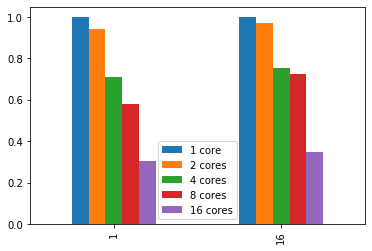

In [51]:
pd.DataFrame(efficiency, columns=["1 core", "2 cores", "4 cores", "8 cores", "16 cores"], index=[1,16]).plot.bar()

**Explanation**

We can observe that adding more cores to this task gives us a sublinear speedup. However if we compare an original dataset with a oversampled one, the latter speedups are higher: We believe that related to more time spent on doing a proper computations on data, which is highly parallelizable. 

The other interesting thing are diminishing gains with adding more and more cores – that's directly related to Amdahl's law.   
The speedup of 16 cores in comparison to 8 cores is minute in original dataset and on a inflated one 16 cores where actually slower than 8.